In [1]:
# Code for Meuse data interpolation exercise
# Author :: Yin Cheng Ng  Date: 11/12/2015
# Dependency: R, sp (R package), numpy, scipy, matplotlib, sklearn, GPy, PBP research code, pandas, rpy2

# Load the libraries
%matplotlib inline
import sys
sys.path.append("../../pbp/Probabilistic-Backpropagation/c/PBP_net")
import pandas as pd
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
import GPy
import PBP_net
import numpy as np

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from sklearn.cross_validation import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from scipy.interpolate import Rbf
pandas2ri.activate()
sp = robjects.packages.importr("sp")
np.random.seed(0)

warning in stationary: failed to import cython module: falling back to numpy


In [2]:
# Import meuse dataset and evaluation grid from R and setup cross-validation iterator
robjects.r("data(meuse)")
robjects.r("data(meuse.grid)")
meuse = robjects.r("meuse")
meuse_grid = robjects.r("meuse.grid")
data = meuse[['x','y', 'cadmium']].values.copy()
np.random.shuffle(data)
inputX = data[:,0:2]
targetY = data[:,2:3]
k_fold_cv = 10
kf = KFold(len(meuse), n_folds=k_fold_cv, random_state=0)

In [4]:
# Cross-validate GP
kf = KFold(len(meuse), n_folds=k_fold_cv, random_state=0)
kfold_diff = np.array([])
i = 0
plt.rcParams['figure.figsize'] = (6,12)
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    trainX_mu = trainX.mean(axis=0); trainX_sd = trainX.std(axis=0)
    trainX = (trainX - trainX_mu)/trainX_sd
    testX = (testX - trainX_mu)/trainX_sd
    trainY_mean = np.log(trainY).mean()
    gpr = GPy.models.GPRegression(trainX, np.log10(trainY) - trainY_mean); 
    gpr.optimize_restarts(5, verbose=False);#gpr.plot()
    pred = 10.**(gpr.predict(testX)[0] + trainY_mean)
    kfold_diff = np.append(kfold_diff, pred - testY)
    #plt.subplot(int(k_fold_cv/2), 2, i)
    #plt.plot(testY, pred, 'ro')
    i += 1
gp_diff = kfold_diff
gp_mae = np.abs(kfold_diff)
gp_mse = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'GP with Squared-exponential Kernel'
print 'rmse: ' + str(np.sqrt(gp_mse.mean()))
print 'mae : ' + str(gp_mae.mean()) 

10-fold CV Error Metrics
GP with Squared-exponential Kernel
rmse: 2.80716903003
mae : 1.63238321159


In [5]:
# KRR grid search for hyperparameter selection
print 'Kernel Ridge Regression - grid search for optimal hyperparameters'
alpha_vec = np.arange(0., 1.025, 0.025)
gamma_vec = np.arange(0., 10.025, 0.025)
param_grid = np.array([np.array([np.tile(alpha_vec, (len(gamma_vec)))])[0], 
                      np.reshape(np.tile(np.array([gamma_vec]), (len(alpha_vec), 1)), (1, -1), order='F')[0]]).T
cv_rmse = np.array([]); cv_mae = np.array([])

for param in param_grid:
    eps = 1e-10
    cv_alpha = param[0]+eps; cv_gamma = param[1]+eps
    kfold_diff = np.array([])
    for train_idx, test_idx in kf:
        trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
        testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
        trainX_mu = trainX.mean(axis=0); trainX_sd = trainX.std(axis=0)
        trainX = (trainX - trainX_mu)/trainX_sd; testX = (testX - trainX_mu)/trainX_sd
        trainY_mean = np.log(trainY).mean()
        
        krr = KernelRidge(alpha=cv_alpha, kernel='rbf', gamma=cv_gamma); 
        krr.fit(trainX, np.log10(trainY) - trainY_mean)
        pred = 10.**(krr.predict(testX) + trainY_mean)
        kfold_diff = np.append(kfold_diff, pred - testY)
    cv_rmse = np.append(cv_rmse, np.sqrt((kfold_diff**2).mean()))
    cv_mae = np.append(cv_mae, np.mean(np.abs(kfold_diff)))
    #print cv_alpha, cv_gamma, np.sqrt((kfold_diff**2).mean()), np.mean(np.abs(kfold_diff))
#print np.argmin(cv_rmse), param_grid[np.argmin(cv_rmse)], cv_rmse[np.argmin(cv_rmse)], cv_mae[np.argmin(cv_rmse)]
#print np.argmin(cv_mae), param_grid[np.argmin(cv_mae)], cv_rmse[np.argmin(cv_mae)], cv_mae[np.argmin(cv_mae)]

Kernel Ridge Regression - grid search for optimal hyperparameters


In [6]:
# Cross-validate KRR
kfold_diff = np.array([])
for train_idx, test_idx in kf:
    cv_alpha = param_grid[np.argmin(cv_mae), 0]+eps; cv_gamma = param_grid[np.argmin(cv_mae), 1]+eps
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    trainX_mu = trainX.mean(axis=0); trainX_sd = trainX.std(axis=0)
    trainX = (trainX - trainX_mu)/trainX_sd; testX = (testX - trainX_mu)/trainX_sd
    trainY_mean = np.log(trainY).mean()    
    krr = KernelRidge(alpha=cv_alpha, kernel='rbf', gamma=cv_gamma); 
    krr.fit(trainX, np.log10(trainY) - trainY_mean)
    pred = 10.**(krr.predict(testX) + trainY_mean)
    kfold_diff = np.append(kfold_diff, pred - testY)
krr_diff = kfold_diff
krr_ae = np.abs(kfold_diff)
krr_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'KRR with Squared-exponential Kernel'
print 'rmse: ' + str(np.sqrt(krr_se.mean()))
print 'mae : ' + str(krr_ae.mean()) 

10-fold CV Error Metrics
KRR with Squared-exponential Kernel
rmse: 2.51549910339
mae : 1.5113250558


In [7]:
# Cross-validate OLS
kfold_diff = np.array([])
i = 0
plt.rcParams['figure.figsize'] = (6,12)
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    trainX_mu = trainX.mean(axis=0); trainX_sd = trainX.std(axis=0)
    trainX = (trainX - trainX_mu)/trainX_sd; testX = (testX - trainX_mu)/trainX_sd
    trainY_mean = np.log(trainY).mean()    
    lr = LinearRegression(copy_X=True); 
    lr.fit(trainX, np.log10(trainY) - trainY_mean)
    pred = 10.**(lr.predict(testX) + trainY_mean)
    kfold_diff = np.append(kfold_diff, pred - testY)
    i += 1
lr_diff = kfold_diff
lr_ae = np.abs(kfold_diff)
lr_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'Linear Regression'
print 'rmse: ' + str(np.sqrt(lr_se.mean()))
print 'mae: ' + str(lr_ae.mean())

10-fold CV Error Metrics
Linear Regression
rmse: 3.48688390424
mae: 2.07778068046


In [8]:
# Cross validate MGP-Zn
gp_kern = GPy.kern.RBF(2)
icm = GPy.util.multioutput.ICM(input_dim = 2, num_outputs=2, kernel = gp_kern)
y_co = np.log10(meuse.zinc).values.reshape((-1, 1))
y_co = y_co - y_co.mean()
x_co_mu = meuse[['x','y']].values.mean(axis=0)
x_co_sd = meuse[['x','y']].values.std(axis=0)
x_co = (meuse[['x','y']].values - x_co_mu)/x_co_sd

kfold_diff = np.array([])
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    trainX = (trainX - x_co_mu)/x_co_sd
    testX = (testX - x_co_mu)/x_co_sd
    trainY_mean = np.log10(trainY).mean()
    mgpr = GPy.models.GPCoregionalizedRegression([trainX, x_co],[np.log10(trainY) - trainY_mean, y_co], kernel=icm)
    mgpr.optimize_restarts(10, verbose = False)
    noise_dict = {'output_index': np.zeros((len(testX),1)).astype(int)}
    pred = 10.**(mgpr.predict(np.c_[testX, np.zeros((len(testX),1))], Y_metadata=noise_dict)[0] + trainY_mean)
    kfold_diff = np.append(kfold_diff, pred - testY)
mgp_zn_diff = kfold_diff
mgp_zn_ae = np.abs(kfold_diff)
mgp_zn_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'Multi-task GP/cokriging with Squared-exponential Kernel'
print 'rmse: ' + str(np.sqrt(mgp_zn_se.mean()))
print 'mae : ' + str(mgp_zn_ae.mean())

10-fold CV Error Metrics
Multi-task GP/cokriging with Squared-exponential Kernel
rmse: 1.56855393707
mae : 1.05596163613


In [9]:
# Cross validate MGP-Cu
gp_kern = GPy.kern.RBF(2)
icm = GPy.util.multioutput.ICM(input_dim = 2, num_outputs=2, kernel = gp_kern)
y_co = np.log10(meuse.copper).values.reshape((-1, 1))
y_co = y_co - y_co.mean()
x_co_mu = meuse[['x','y']].values.mean(axis=0)
x_co_sd = meuse[['x','y']].values.std(axis=0)
x_co = (meuse[['x','y']].values - x_co_mu)/x_co_sd

kfold_diff = np.array([])
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    trainX = (trainX - x_co_mu)/x_co_sd
    testX = (testX - x_co_mu)/x_co_sd
    trainY_mean = np.log10(trainY).mean()
    mgpr = GPy.models.GPCoregionalizedRegression([trainX, x_co],[np.log10(trainY) - trainY_mean, y_co], kernel = icm)
    mgpr.optimize_restarts(10, verbose = False)
    noise_dict = {'output_index': np.zeros((len(testX),1)).astype(int)}
    pred = 10.**(mgpr.predict(np.c_[testX, np.zeros((len(testX),1))], Y_metadata=noise_dict)[0] + trainY_mean)
    kfold_diff = np.append(kfold_diff, pred - testY)
mgp_cop_diff = kfold_diff
mgp_cop_ae = np.abs(kfold_diff)
mgp_cop_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'Multi-task GP/cokriging with Squared-exponential Kernel'
print 'rmse: ' + str(np.sqrt(mgp_cop_se.mean()))
print 'mae : ' + str(mgp_cop_ae.mean())

10-fold CV Error Metrics
Multi-task GP/cokriging with Squared-exponential Kernel
rmse: 1.90159042118
mae : 1.17745774057


In [11]:
# Cross validate MGP-Pb
gp_kern = GPy.kern.RBF(2)
icm = GPy.util.multioutput.ICM(input_dim = 2, num_outputs=2, kernel = gp_kern)
y_co = np.log10(meuse.lead).values.reshape((-1, 1))
y_co = y_co - y_co.mean()
x_co_mu = meuse[['x','y']].values.mean(axis=0)
x_co_sd = meuse[['x','y']].values.std(axis=0)
x_co = (meuse[['x','y']].values - x_co_mu)/x_co_sd

kfold_diff = np.array([])
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    trainX = (trainX - x_co_mu)/x_co_sd
    testX = (testX - x_co_mu)/x_co_sd
    trainY_mean = np.log10(trainY).mean()
    mgpr = GPy.models.GPCoregionalizedRegression([trainX, x_co],[np.log10(trainY) - trainY_mean, y_co], kernel = icm)
    mgpr.optimize_restarts(10, verbose = False)
    noise_dict = {'output_index': np.zeros((len(testX),1)).astype(int)}
    pred = 10.**(mgpr.predict(np.c_[testX, np.zeros((len(testX),1))], Y_metadata=noise_dict)[0] + trainY_mean)
    kfold_diff = np.append(kfold_diff, pred - testY)
mgp_lead_diff = kfold_diff
mgp_lead_ae = np.abs(kfold_diff)
mgp_lead_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'Multi-task GP/cokriging with Squared-exponential Kernel'
print 'rmse: ' + str(np.sqrt(mgp_lead_se.mean()))
print 'mae : ' + str(mgp_lead_ae.mean())

10-fold CV Error Metrics
Multi-task GP/cokriging with Squared-exponential Kernel
rmse: 2.09806489512
mae : 1.35706423035


In [12]:
# Cross validate PBP-50
kfold_diff = np.array([])
i = 0
n_hidden_units = 50
plt.rcParams['figure.figsize'] = (6,12)
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    #trainX_mu = trainX.mean(axis=0); trainX_sd = trainX.std(axis=0)
    #trainX = (trainX - trainX_mu)/trainX_sd; testX = (testX - trainX_mu)/trainX_sd   
    net = PBP_net.PBP_net(trainX, np.log10(trainY.T[0]),
        [ n_hidden_units, n_hidden_units ], normalize = True, n_epochs = 20000) 
    pred, v, v_noise = net.predict(testX)
    pred = np.reshape(10. ** pred, (-1, 1))
    kfold_diff = np.append(kfold_diff, pred - testY)
    #plt.subplot(int(k_fold_cv/2), 2, i)
    #plt.plot(testY, pred, 'ro')
    i += 1
pbp_diff = kfold_diff
pbp_ae = np.abs(kfold_diff)
pbp_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'PBP-50'
print 'rmse: ' + str(np.sqrt(pbp_se.mean()))
print 'mae: ' + str(pbp_ae.mean())

9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
10-fold CV Error Metrics
PBP-50
rmse: 2.71351141806
mae: 1.52036833569


In [16]:
# Cross validate PBP-60
kfold_diff = np.array([])
i = 0
n_hidden_units = 60
plt.rcParams['figure.figsize'] = (6,12)
for train_idx, test_idx in kf:
    trainX = inputX[train_idx].copy(); trainY = targetY[train_idx].copy()
    testX = inputX[test_idx].copy(); testY = targetY[test_idx].copy()
    #trainX_mu = trainX.mean(axis=0); trainX_sd = trainX.std(axis=0)
    #trainX = (trainX - trainX_mu)/trainX_sd; testX = (testX - trainX_mu)/trainX_sd   
    net = PBP_net.PBP_net(trainX, np.log10(trainY.T[0]),
        [ n_hidden_units, n_hidden_units ], normalize = True, n_epochs = 20000) 
    pred, v, v_noise = net.predict(testX)
    pred = np.reshape(10. ** pred, (-1, 1))
    kfold_diff = np.append(kfold_diff, pred - testY)
    #plt.subplot(int(k_fold_cv/2), 2, i)
    #plt.plot(testY, pred, 'ro')
    i += 1
pbp60_diff = kfold_diff
pbp60_ae = np.abs(kfold_diff)
pbp60_se = kfold_diff ** 2
print str(k_fold_cv) + '-fold CV Error Metrics'
print 'PBP-60'
print 'rmse: ' + str(np.sqrt(pbp60_se.mean()))
print 'mae: ' + str(pbp60_ae.mean())

9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
9999
19999
10-fold CV Error Metrics
PBP-60
rmse: 2.87630139059
mae: 1.58656186728


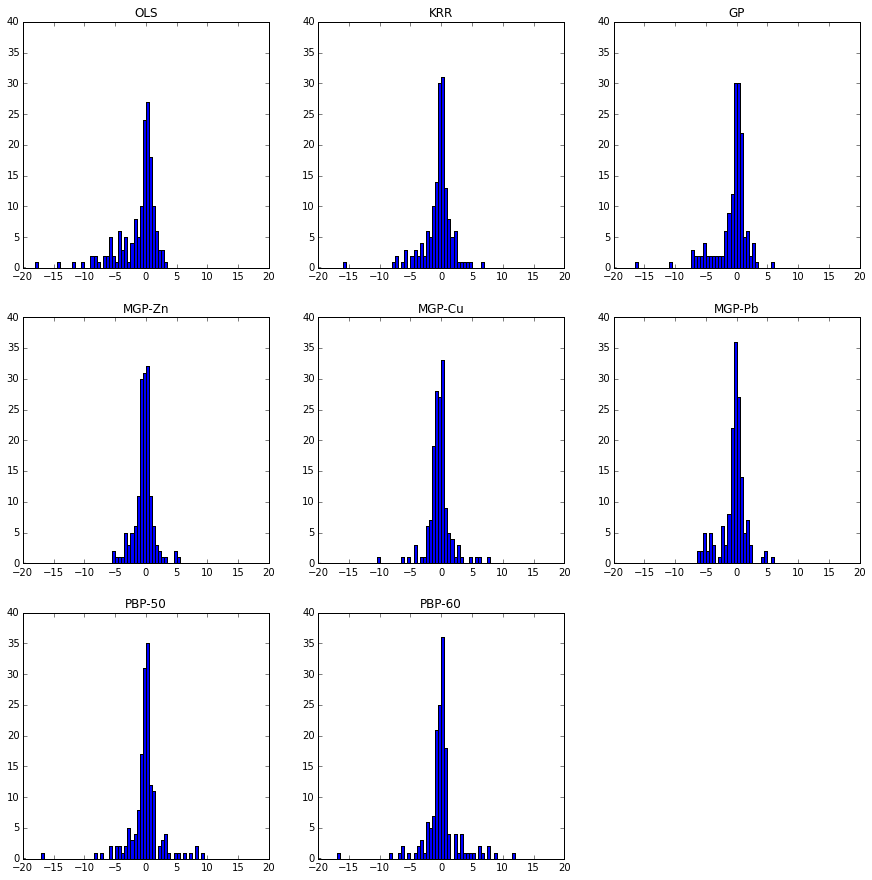

In [39]:
# Generate residual histograms
plt.rcParams['figure.figsize'] = (15,15)
plt.subplot(3,3,1)
plt.hist(lr_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(lr_diff))
plt.ylim((0,40))
plt.title('OLS')

plt.subplot(3,3,2)
plt.hist(krr_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(krr_diff))
plt.ylim((0,40))
plt.title('KRR')

plt.subplot(3,3,3)
plt.hist(gp_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(krr_diff))
plt.ylim((0,40))
plt.title('GP')

plt.subplot(3,3,4)
plt.hist(mgp_zn_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(mgp_zn_diff))
plt.ylim((0,40))
plt.title('MGP-Zn')

plt.subplot(3,3,5)
plt.hist(mgp_cop_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(mgp_cop_diff))
plt.ylim((0,40))
plt.title('MGP-Cu')

plt.subplot(3,3,6)
plt.hist(mgp_lead_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(mgp_lead_diff))
plt.ylim((0,40))
plt.title('MGP-Pb')

plt.subplot(3,3,7)
plt.hist(pbp_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(pbp_diff))
plt.ylim((0,40))
plt.title('PBP-50')

plt.subplot(3,3,8)
plt.hist(pbp60_diff, bins = np.arange(-20.,20.,.5))
#print np.max(np.abs(pbp60_diff))
plt.ylim((0,40))
plt.title('PBP-60')

Pearson Correlation Coefficients
          cadmium        om    copper      zinc      lead
cadmium  1.000000  0.483732  0.836333  0.862448  0.812452
om       0.483732  1.000000  0.626617  0.586687  0.529800
copper   0.836333  0.626617  1.000000  0.897151  0.842893
zinc     0.862448  0.586687  0.897151  1.000000  0.967162
lead     0.812452  0.529800  0.842893  0.967162  1.000000

Spearman Correlation Coefficients
          cadmium        om    copper      zinc      lead
cadmium  1.000000  0.616382  0.884956  0.904295  0.862995
om       0.616382  1.000000  0.662626  0.653313  0.597589
copper   0.884956  0.662626  1.000000  0.899403  0.868394
zinc     0.904295  0.653313  0.899403  1.000000  0.961849
lead     0.862995  0.597589  0.868394  0.961849  1.000000


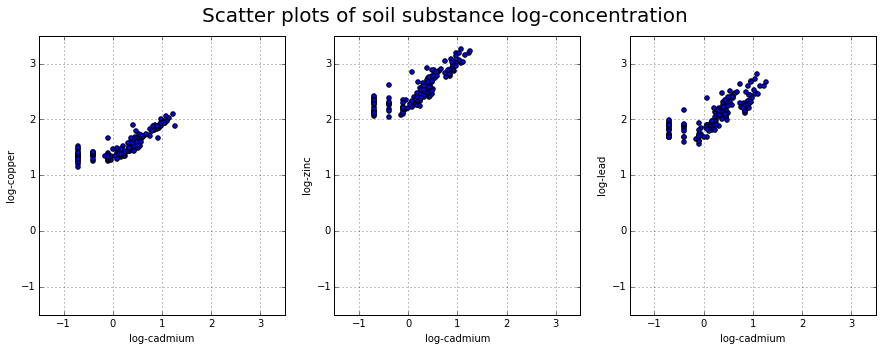

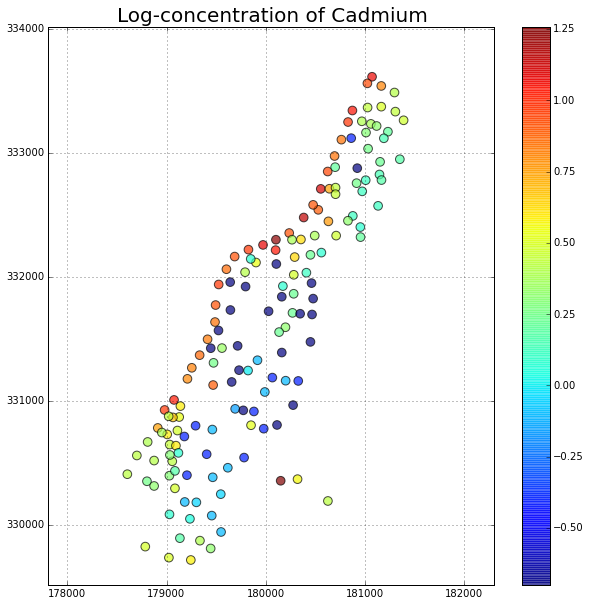

In [38]:
# Visualize Meuse data
print 'Pearson Correlation Coefficients'
print np.log10(meuse[['cadmium', 'om', 'copper', 'zinc', 'lead']]).corr()
print 
print 'Spearman Correlation Coefficients'
print np.log10(meuse[['cadmium', 'om', 'copper', 'zinc', 'lead']]).corr('spearman')

plt.rcParams['figure.figsize']= (15,5)
plt.subplot(1,3,1)
plt.scatter(np.log10(meuse.cadmium), np.log10(meuse.copper))
plt.xlabel('log-cadmium'); plt.ylabel('log-copper'); plt.grid()
#plt.xlim((-1.,2.2));plt.ylim((-1.,2.2))
plt.xlim((-1.5,3.5));plt.ylim((-1.5,3.5))
plt.subplot(1,3,2)
plt.scatter(np.log10(meuse.cadmium), np.log10(meuse.zinc))
plt.xlabel('log-cadmium'); plt.ylabel('log-zinc'); plt.grid()
#plt.xlim((-1.,3.4));plt.ylim((-1.,3.4))
plt.xlim((-1.5,3.5));plt.ylim((-1.5,3.5))
plt.subplot(1,3,3)
plt.scatter(np.log10(meuse.cadmium), np.log10(meuse.lead))
#plt.xlim((-1.,3.));plt.ylim((-1.,3.))
plt.xlim((-1.5,3.5));plt.ylim((-1.5,3.5))
plt.xlabel('log-cadmium'); plt.ylabel('log-lead'); plt.grid()
plt.suptitle('Scatter plots of soil substance log-concentration', fontsize=20)

plt.rcParams['figure.figsize']= (10,10)
plt.figure()

plt.scatter(meuse['x'], meuse['y'], s = 75., c = np.log10(meuse.cadmium), alpha = 0.7)
plt.xlim((np.min(meuse['x'])-800.,np.min(meuse['x'])-800.+4500. ))
plt.ylim((np.min(meuse['y'])-200.,np.min(meuse['y'])-200.+4500))
plt.colorbar()
plt.title('Log-concentration of Cadmium', fontsize = 20)
plt.grid()

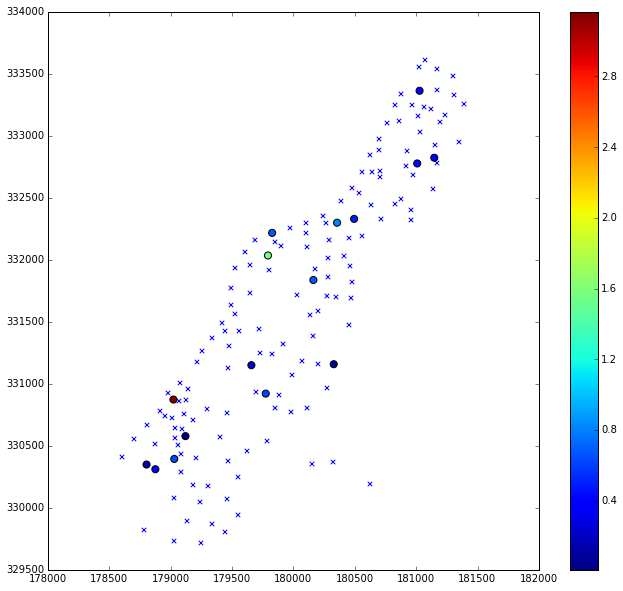

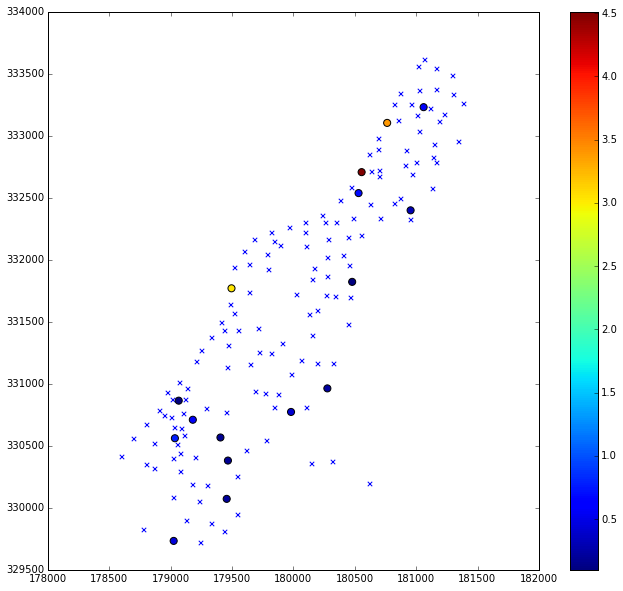

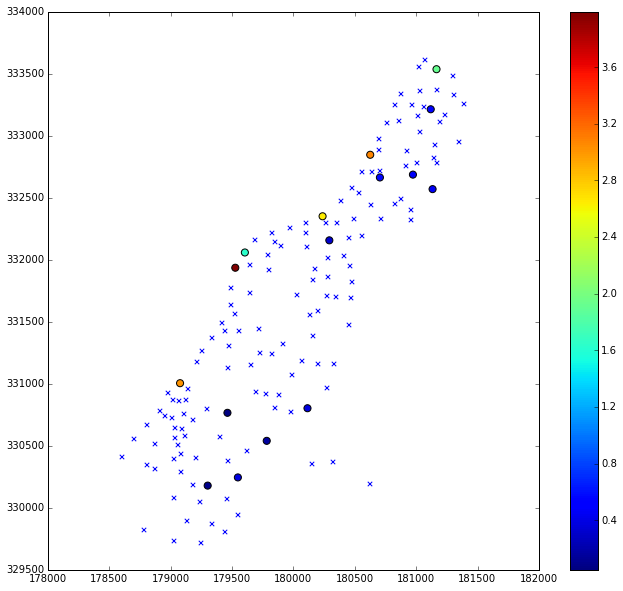

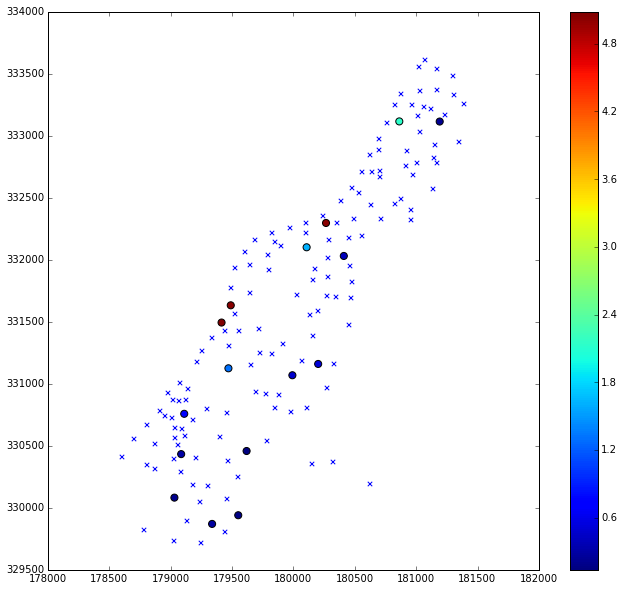

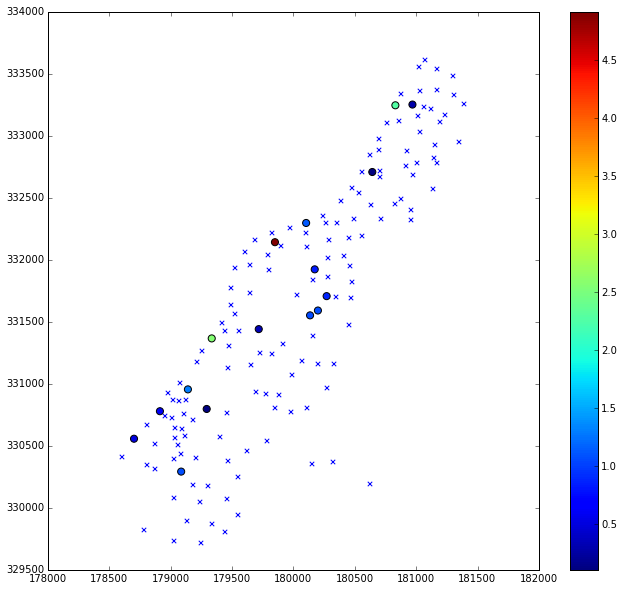

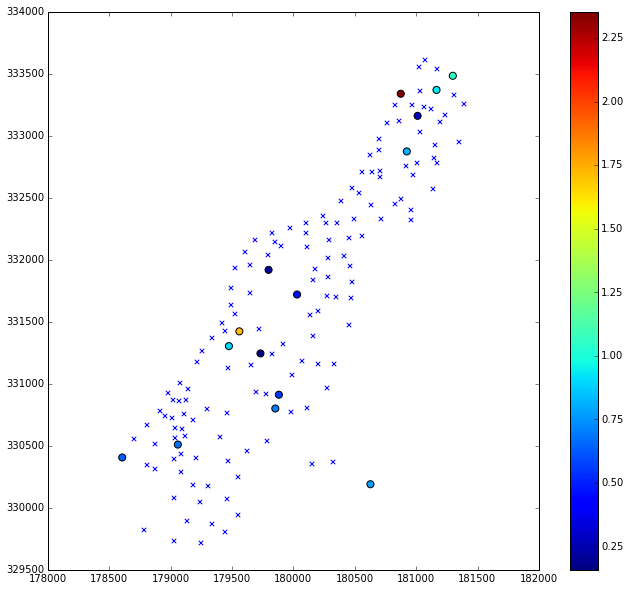

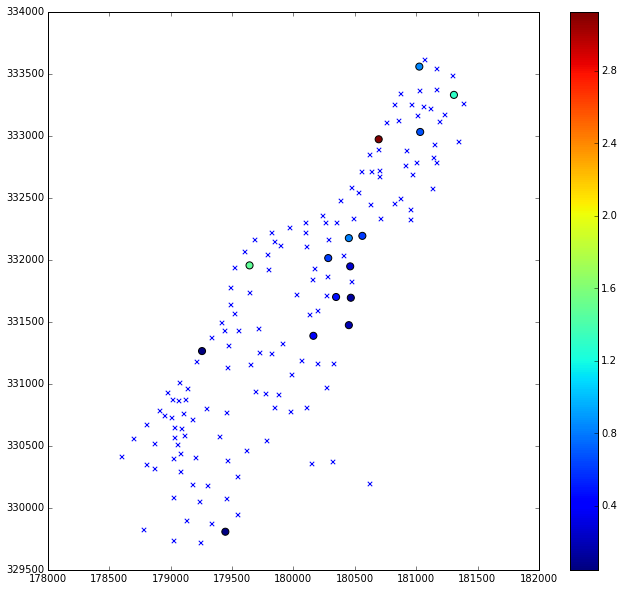

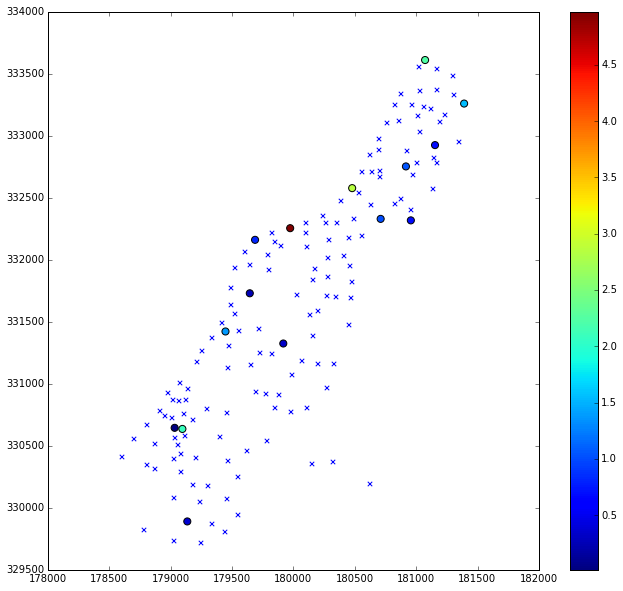

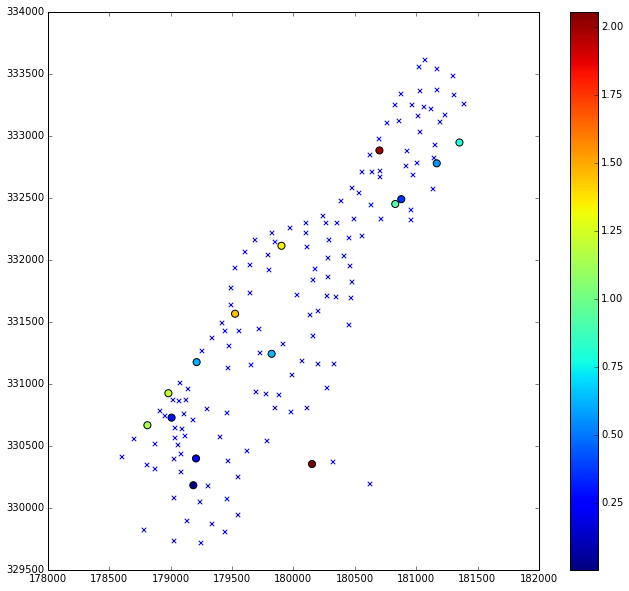

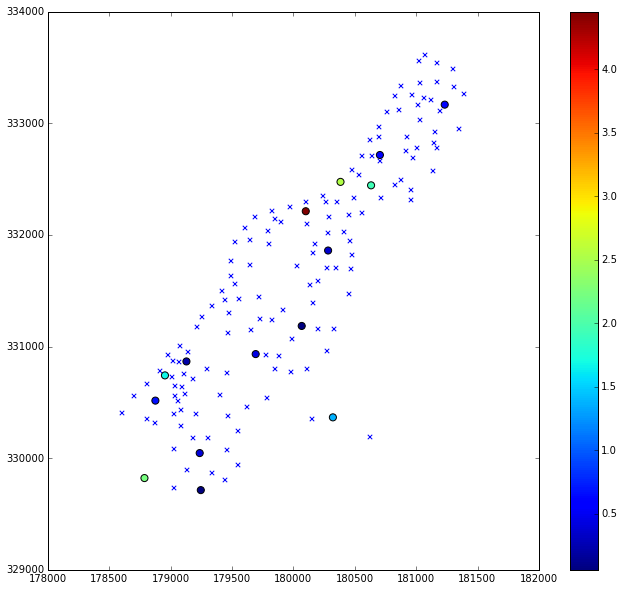

In [40]:
# Generate scatter plot of cross-validation error for debugging
plt.rcParams['figure.figsize'] = (11,10)
for train_idx, test_idx in kf:
    plt.figure()
    plt.scatter(data[train_idx, 0], data[train_idx,1], marker='x')
    plt.scatter(data[test_idx,0], data[test_idx,1], c = np.abs(mgp_zn_diff[test_idx]), s = 50)
    plt.colorbar()